# Buzzer control analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'buzzer'  # Analysis type
mouseline = 'line3' # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # variable of interest for post-processing

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain,
    baseline_wlen, baseline_quantile, baseline_smoothing,
    ykey_postpro)

# Derive output metrics of interest
outkey = get_change_key(ykey_postpro)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 25/10/2022 10:38:35: assembling batch analysis settings...
 25/10/2022 10:38:35: line3 batch notebook started on 2022-10-25 at 10:38:35


### Input summary table figure

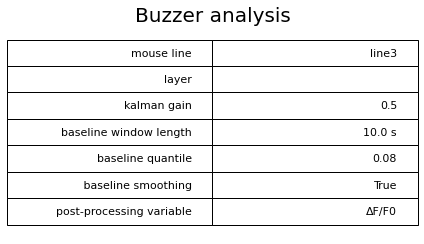

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Buzzer analysis')

## Input data

### Load data

In [6]:
# Determine what to do in case of duplicate runs
on_duplicate_runs = 'pass'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, include_mode='any',
    on_duplicate_runs=on_duplicate_runs, harmonize_runs=False, 
    condition='buzzer')

 25/10/2022 10:38:35: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/buzzer/line3:
 25/10/2022 10:38:35: loading trial-averaged data from 20190719_mouse1_region2.h5
 25/10/2022 10:38:35: loading trial-averaged data from 20190719_mouse2_region1.h5
 25/10/2022 10:38:35: gathering dataset IDs...
 25/10/2022 10:38:35: sorting dataset indexes...
 25/10/2022 10:38:35: adding post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) metrics to stats dataset...
 25/10/2022 10:38:35: applying series_avg function on Z(ΔF/F0) in [5-10] index window across dataset, ROI, run ...
 25/10/2022 10:38:35: applying series_avg function on Z(ΔF/F0) in [10-19] index window across dataset, ROI, run ...
 25/10/2022 10:38:35: datasets successfully loaded


### Filter out datasets, classify cells and show breakdown & map per dataset

 25/10/2022 10:39:45: extracting timeseries and stats from data...
 25/10/2022 10:39:45: excluding datasets with missing conditions...
 25/10/2022 10:39:45: cell breakdown:
  - weak: 581 (67.4%)
  - positive: 281 (32.6%)
 25/10/2022 10:39:45: extracting responses types per ROI...
 25/10/2022 10:39:45: plotting cells map color-coded by response type...
 25/10/2022 10:39:47: extracting responses types per ROI...
 25/10/2022 10:39:47: plotting cells map color-coded by response type...
 25/10/2022 10:39:48: restricting dataset to positive responders only...


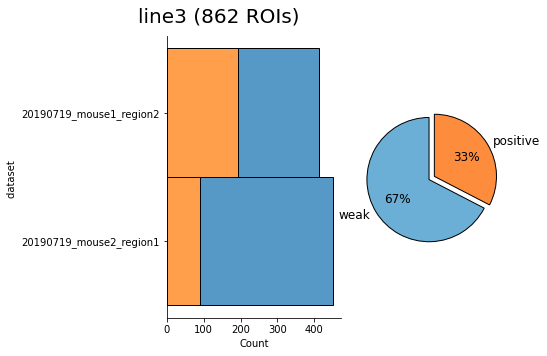

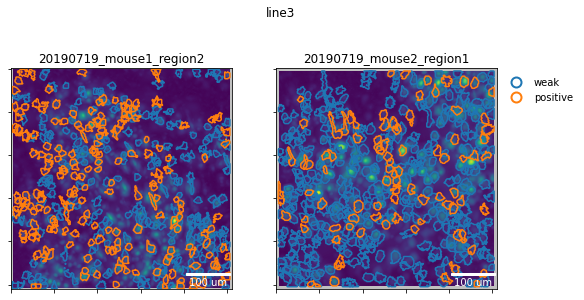

In [15]:
# Extract fields from data
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Create conditions column with better names
ckey = 'condition'
condkeys_map = {
    'sound': 'sound',
    'tus': 'US',
    'sound_tus': 'sound+US'
}
stats[ckey] = stats[Label.SUFFIX].map(condkeys_map)

# Exclude datasets with missing conditions
logger.info('excluding datasets with missing conditions...')
ncondsperdataset = stats[ckey].groupby(Label.DATASET).nunique()
valid_datasets = ncondsperdataset[ncondsperdataset == 3].index
timeseries = timeseries.loc[pd.IndexSlice[valid_datasets]]
stats = stats.loc[pd.IndexSlice[valid_datasets]]
ROI_masks = ROI_masks.loc[pd.IndexSlice[valid_datasets]]
map_ops = {k: map_ops[k] for k in valid_datasets}

# Compute number of occurences per response type per ROI
roistats = stats[Label.RESP_TYPE].groupby(
    [Label.DATASET, Label.ROI]).value_counts().unstack().replace(np.nan, 0.).astype(int)

# Classify ROIs based on number of responsive conditions
roistats[Label.ROI_RESP_TYPE] = 'weak'
roistats.loc[roistats['positive'] >= 1, Label.ROI_RESP_TYPE] = 'positive'

# Log number and percentage of cells of each type identified
ncells_per_type = roistats[Label.ROI_RESP_TYPE].value_counts()
ncells_tot = ncells_per_type.sum()
logstr = []
for rtype, count in ncells_per_type.iteritems():
    logstr.append(f'  - {rtype}: {count} ({count / ncells_tot * 100:.1f}%)')
logstr = "\n".join(logstr)
logger.info(f'cell breakdown:\n{logstr}')

# Add roistats to stats
stats = expand_and_add(roistats, stats.copy())

# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(stats, title=mouseline)
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

# Restrict analysis to positive responders
logger.info('restricting dataset to positive responders only...')
mux_pos = stats[stats[Label.ROI_RESP_TYPE] == 'positive'].index.droplevel(-1).unique()
idx_pos = pd.IndexSlice[mux_pos.get_level_values(0), mux_pos.get_level_values(1)]
stats = stats.loc[idx_pos, :]
timeseries = timeseries.loc[idx_pos, :]

### Plot responders traces vs variable offset

 25/10/2022 10:39:50: assembling plot data...
 25/10/2022 10:39:50: adding time info to table...
 25/10/2022 10:39:50: plotting responders traces across conditions & datasets...
 25/10/2022 10:39:50: plotting aggregate responders traces across conditions...


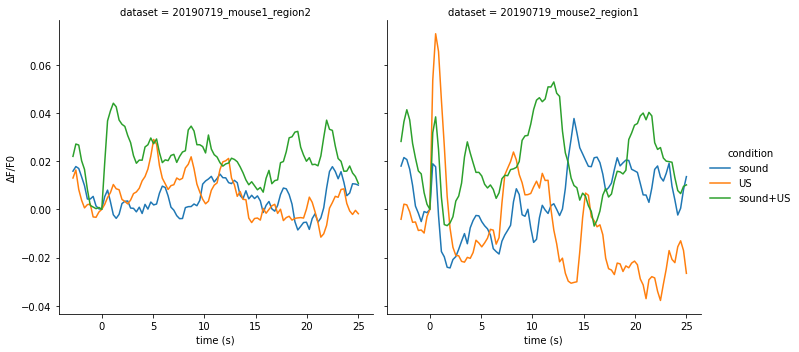

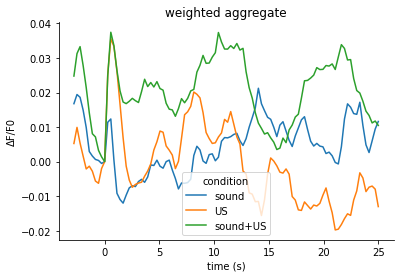

In [16]:
# Get plot data
logger.info('assembling plot data...')
pltdata = expand_and_add(stats[ckey], timeseries.copy())
# Add time
fps = get_singleton(stats, Label.FPS)
pltdata = add_time_to_table(pltdata, fps=fps)

# Plot parameters
palette = None
ci = None

# Plot response traces vs. offset for each dataset
logger.info('plotting responders traces across conditions & datasets...')
fg = sns.relplot(
    data=pltdata, x=Label.TIME, y=ykey_postpro, kind='line',
    hue=ckey, col=Label.DATASET, ci=ci, hue_order=condkeys_map.values())
figs['traces_vs_offset_per_dataset'] = fg.figure

# Plot weighted aggregate response traces vs. offset
logger.info('plotting aggregate responders traces across conditions...')
figs['traces_vs_offset_agg'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('weighted aggregate')
sns.lineplot(
    data=pltdata, x=Label.TIME, y=ykey_postpro, ax=ax,
    hue=ckey, ci=ci, hue_order=condkeys_map.values());

### Plot response strength per condition

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

20190719_mouse2_region1_US vs. 20190719_mouse2_region1_sound+US: Mann-Whitney-Wilcoxon test two-sided, P_val:1.333e-04 U_stat=1.852e+04
20190719_mouse1_region2_sound vs. 20190719_mouse1_region2_US: Mann-Whitney-Wilcoxon test two-sided, P_val:7.153e-03 U_stat=1.870e+04
20190719_mouse1_region2_US vs. 20190719_mouse1_region2_sound+US: Mann-Whitney-Wilcoxon test two-sided, P_val:1.830e-14 U_stat=1.252e+04
20190719_mouse2_region1_sound vs. 20190719_mouse2_region1_US: Mann-Whitney-Wilcoxon test two-sided, P_val:1.669e-09 U_stat=9.357e+03
20190719_mouse2_region1_sound vs. 20190719_mouse2_region1_sound+US: Mann-Whitney-Wilcoxon test two-sided, P_val:3.820e-03 U_stat=1.227e+04
20190719_mouse1_region2_sound vs. 20190719_mouse1_region2_sound+US: Mann-Whitney-Wilcoxon test two-sided, P_val:9.022e-22 U_stat=1.012e+04


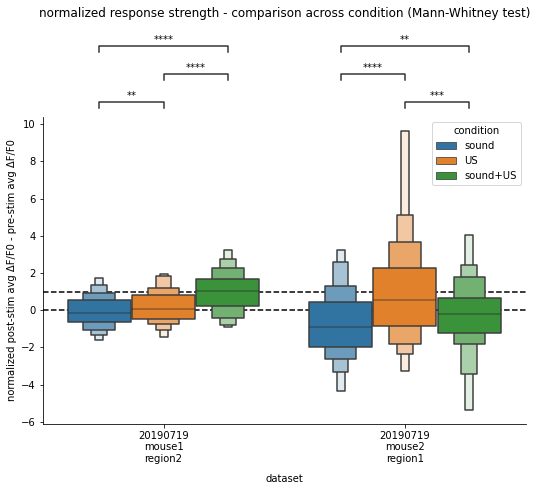

In [17]:
# Get output change key
outkey = get_change_key(ykey_postpro)

# Compute normalized response strength for each dataset

maxperdataset = stats.groupby([Label.DATASET, ckey])[outkey].mean().groupby(Label.DATASET).max()
normkey = f'normalized {outkey}'
stats[normkey] = stats[outkey] / maxperdataset

figs['paired_comps'] = plot_comparative_metrics_across_datasets(
    stats.copy(), normkey, ckey, kind='boxen', showfliers=False,
    hue_order=condkeys_map.values())

### Save figures

In [10]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 25/10/2022 10:38:42: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.10.25/figs_buzzer_line3_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 6/6 [00:00<00:00,  7.28it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 25/10/2022 10:38:43: line3 batch notebook completed in 0:00:08.063307 s
